In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

### Gradient boost guided example

Having walked through gradient boost by hand, now let's try it with SKlearn.  We'll still use the European Social Survey Data, but now with a categorical outcome: Whether or not someone lives with a partner.

In [2]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

## Original Model before Feature Engineering

In [3]:
# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

In [4]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function to deviance.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance',
         'subsample': 1}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

score_train = clf.score(X_train, y_train)
score_test = clf.score(X_test, y_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'R-squared Score: {}\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'R-squared Score: {}\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(score_train, train_tI_errors, train_tII_errors, score_test, test_tI_errors, test_tII_errors))


Training set accuracy:
R-squared Score: 0.7774140752864157
Percent Type I errors: 0.04650845608292417
Percent Type II errors: 0.17607746863066012

Test set accuracy:
R-squared Score: 0.7521472392638037
Percent Type I errors: 0.06257668711656442
Percent Type II errors: 0.18527607361963191


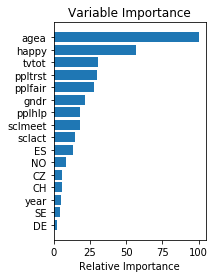

In [5]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

It appears that age and happiness are the most important features in predicting whether or not someone lives with a partner. 

### DRILL: Improve this gradient boost model

While this model is already doing alright, we've seen from the Type I and Type II error rates that there is definitely room for improvement.  Your task is to see how low you can get the error rates to go in the test set, based on your model in the training set.  Strategies you might use include:

* Creating new features
* Applying more overfitting-prevention strategies like subsampling
* More iterations
* Trying a different loss function
* Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications

Have fun!

## Feature Engineering
I will start by making some additional features.  To begin, I will inspect the boxplots of distributions of the variables for people with partners or not, and then report the t-values to determine whether or not the differences between the variables are significant.  

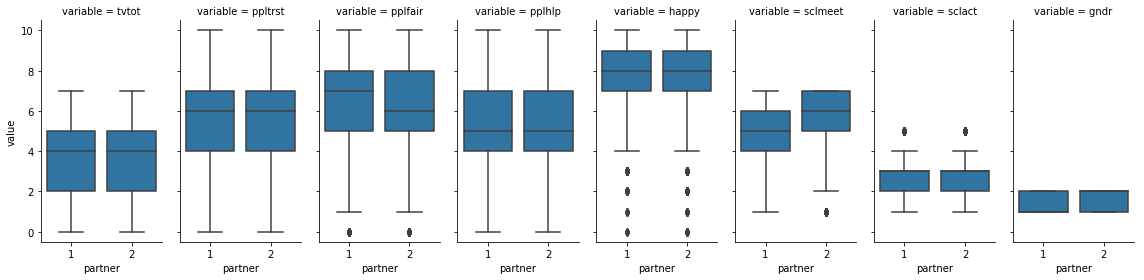

In [6]:
#setting up dataframe for boxplot of parters or no partners
dfl = df.drop(['agea', 'cntry', 'idno', 'year'], axis=1)
df_long = pd.melt(dfl, id_vars=['partner'])
g = sns.FacetGrid(df_long, col='variable', size=4, aspect=0.5)
g = g.map(sns.boxplot, 'partner', 'value', order=[1,2])
plt.show()

In [7]:
from scipy.stats import ttest_ind

for col in dfl.columns:
    t_val, p_val = ttest_ind(
        dfl[dfl['partner']==1][col],
        dfl[dfl['partner']==2][col])
    print('{}\t{}'.format(col, p_val))

tvtot	0.009292883328083916
ppltrst	0.0019168232030961356
pplfair	0.002110868444877708
pplhlp	0.04637745129936481
happy	1.471156645338203e-39
sclmeet	1.3276688249963506e-49
sclact	0.303332737769568
gndr	0.002156458353009423
partner	0.0


According to these boxplots, all variables are significantly different from one another, with the exception of social activities. For this reason, I will remove social activities from the feature set. It is also apparent from the boxplots that ratings for people with partners meeting people socially is significantly higher than for people without partners. 

In [8]:
X = X.drop(['sclact'], axis=1)

After inspecting the distributions of variables, I want to know if the variables are related to one another or not.  To achieve this, I will inspect the correlations between variables through a heat map to determine how related the variables are to one another.

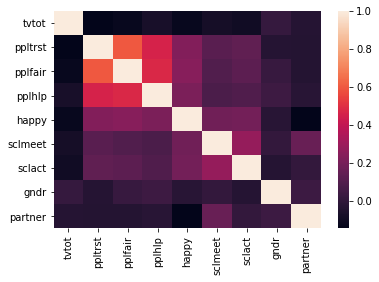

,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,partner
tvtot,1.000000,-0.142422,-0.119277,-0.069080,-0.118598,-0.078864,-0.092375,0.017922,-0.028816
ppltrst,-0.142422,1.000000,0.597506,0.459250,0.231533,0.122555,0.137491,-0.029921,-0.034371
pplfair,-0.119277,0.597506,1.000000,0.480931,0.247755,0.096501,0.128808,0.022251,-0.034054
pplhlp,-0.069080,0.459250,0.480931,1.000000,0.215323,0.080489,0.092673,0.042046,-0.022069
happy,-0.118598,0.231533,0.247755,0.215323,1.000000,0.182944,0.192030,-0.022413,-0.145061
sclmeet,-0.078864,0.122555,0.096501,0.080489,0.182944,1.000000,0.283319,0.009533,0.162970
sclact,-0.092375,0.137491,0.128808,0.092673,0.192030,0.283319,1.000000,-0.031648,0.011405
gndr,0.017922,-0.029921,0.022251,0.042046,-0.022413,0.009533,-0.031648,1.000000,0.033984
partner,-0.028816,-0.034371,-0.034054,-0.022069,-0.145061,0.162970,0.011405,0.033984,1.000000


In [9]:
corrmat = dfl.corr()
sns.heatmap(corrmat)
plt.show()
corrmat

In thinking about these variables, it would make sense that if people trust other people, they would also believe that people are fair and that people help them.  For this reason, I will engineer a feature that combines all three variables together. 

In [10]:
#combining variables related to trust, helpfulness, and fairness
X['ppltrst_pplhlp_pplfair'] = df['ppltrst'] * df['pplhlp'] * df['pplfair']
X = X.drop(['ppltrst', 'pplhlp', 'pplfair'], axis=1)

Now, using these engineered variables, I will finish getting the dataset ready for modeling and then separate the data into train and test datasets.

In [11]:
# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

Since we're now working with a binary outcome, we've switched to a classifier.  Now our loss function can't be the residuals.  Our options are "deviance", or "exponential".  Deviance is used for logistic regression, and we'll try that here.

## Initial Model with Engineered Features

In [12]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function to deviance.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance',
         'subsample': 1}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

score_train = clf.score(X_train, y_train)
score_test = clf.score(X_test, y_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'R-squared Score: {}\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'R-squared Score: {}\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(score_train, train_tI_errors, train_tII_errors, score_test, test_tI_errors, test_tII_errors))


Training set accuracy:
R-squared Score: 0.774822695035461
Percent Type I errors: 0.04828150572831424
Percent Type II errors: 0.17689579923622475

Test set accuracy:
R-squared Score: 0.750920245398773
Percent Type I errors: 0.05889570552147239
Percent Type II errors: 0.1901840490797546


Unlike decision trees, gradient boost solutions are not terribly easy to interpret on the surface.  But they aren't quite a black box.  We can get a measure of how important various features are by counting how many times a feature is used over the course of many decision trees.

### 1000 Iterations
To improve this same model, I will increase the number of iterations of the model to determine how this impacts that error rates. 

In [13]:
# We'll make 1000 iterations, use 2-deep trees, and set our loss function to deviance.
params = {'n_estimators': 1000,
          'max_depth': 2,
          'loss': 'deviance',
         'subsample': 1}

# Initialize and fit the model.
clf2 = ensemble.GradientBoostingClassifier(**params)
clf2.fit(X_train, y_train)

predict_train2 = clf2.predict(X_train)
predict_test2 = clf2.predict(X_test)

score_train2 = clf2.score(X_train, y_train)
score_test2 = clf2.score(X_test, y_test)

# Accuracy tables.
table_train2 = pd.crosstab(y_train, predict_train2, margins=True)
table_test2 = pd.crosstab(y_test, predict_test2, margins=True)

train_tI_errors2 = table_train2.loc[0.0,1.0] / table_train2.loc['All','All']
train_tII_errors2 = table_train2.loc[1.0,0.0] / table_train2.loc['All','All']

test_tI_errors2 = table_test2.loc[0.0,1.0]/table_test2.loc['All','All']
test_tII_errors2 = table_test2.loc[1.0,0.0]/table_test2.loc['All','All']

print((
    'Training set accuracy:\n'
    'R-squared Score: {}\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'R-squared Score: {}\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(score_train2, train_tI_errors2, train_tII_errors2, score_test2, test_tI_errors2, test_tII_errors2))


Training set accuracy:
R-squared Score: 0.78696126568467
Percent Type I errors: 0.04350791052918712
Percent Type II errors: 0.16953082378614293

Test set accuracy:
R-squared Score: 0.758282208588957
Percent Type I errors: 0.06625766871165645
Percent Type II errors: 0.1754601226993865


Increasing the number of iterations caused a slight increase in the the time the model took to run.  This change decreased the type 2 errors in the test set by 2%, but the type 1 errors increased by less than a percent.

I will now try another model with even more iterations as the last model, with 2000 iterations. 

### 2000 Iterations

In [14]:
# We'll make 2000 iterations, use 4-deep trees, and set our loss function to deviance.
params = {'n_estimators': 2000,
          'max_depth': 1,
          'loss': 'deviance',
         'subsample': 1}

# Initialize and fit the model.
clf3 = ensemble.GradientBoostingClassifier(**params)
clf3.fit(X_train, y_train)

predict_train3 = clf3.predict(X_train)
predict_test3 = clf3.predict(X_test)

score_train3 = clf3.score(X_train, y_train)
score_test3 = clf3.score(X_test, y_test)

# Accuracy tables.
table_train3 = pd.crosstab(y_train, predict_train3, margins=True)
table_test3 = pd.crosstab(y_test, predict_test3, margins=True)

train_tI_errors3 = table_train3.loc[0.0,1.0] / table_train3.loc['All','All']
train_tII_errors3 = table_train3.loc[1.0,0.0] / table_train3.loc['All','All']

test_tI_errors3 = table_test3.loc[0.0,1.0]/table_test3.loc['All','All']
test_tII_errors3 = table_test3.loc[1.0,0.0]/table_test3.loc['All','All']

print((
    'Training set accuracy:\n'
    'R-squared Score: {}\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'R-squared Score: {}\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(score_train3, train_tI_errors3, train_tII_errors3, score_test3, test_tI_errors3, test_tII_errors3))


Training set accuracy:
R-squared Score: 0.756683033278778
Percent Type I errors: 0.04705400981996727
Percent Type II errors: 0.19626295690125478

Test set accuracy:
R-squared Score: 0.7423312883435583
Percent Type I errors: 0.05030674846625767
Percent Type II errors: 0.20736196319018405


This increase number of iterations decreased the false positive errors by a full percent in the test set, but increased the false negatives by 3%.  The overall accuracy of the model was more accurate with 1000 iterations, so we will continue with that number of iterations.  Now, I'll increase the max depth of the tree to 3 to see how this impacts the accuracy of the model.

### Max Depth 3

In [15]:
# We'll make 1000 iterations, use 3-deep trees, and set our loss function to deviance.
params = {'n_estimators': 1000,
          'max_depth': 3,
          'loss': 'deviance',
         'subsample': 1}

# Initialize and fit the model.
clf4 = ensemble.GradientBoostingClassifier(**params)
clf4.fit(X_train, y_train)

predict_train4 = clf4.predict(X_train)
predict_test4 = clf4.predict(X_test)

score_train4 = clf4.score(X_train, y_train)
score_test4 = clf4.score(X_test, y_test)

# Accuracy tables.
table_train4 = pd.crosstab(y_train, predict_train4, margins=True)
table_test4 = pd.crosstab(y_test, predict_test4, margins=True)

train_tI_errors4 = table_train4.loc[0.0,1.0] / table_train4.loc['All','All']
train_tII_errors4 = table_train4.loc[1.0,0.0] / table_train4.loc['All','All']

test_tI_errors4 = table_test4.loc[0.0,1.0]/table_test4.loc['All','All']
test_tII_errors4 = table_test4.loc[1.0,0.0]/table_test4.loc['All','All']

print((
    'Training set accuracy:\n'
    'R-squared Score: {}\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'R-squared Score: {}\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(score_train4, train_tI_errors4, train_tII_errors4, score_test4, test_tI_errors4, test_tII_errors4))


Training set accuracy:
R-squared Score: 0.828696126568467
Percent Type I errors: 0.031642116748499725
Percent Type II errors: 0.13966175668303327

Test set accuracy:
R-squared Score: 0.7460122699386503
Percent Type I errors: 0.08711656441717791
Percent Type II errors: 0.1668711656441718


Increasing the number of levels slightly increased the number of type 1 errors, by 2%, but decreased the type 2 errors by around 1%.  This is the opposite trend of accuracy changes that happened when I increased the number of iterations to 2000.  I will try both parameter changes together to see what effect this has on error rates.

### Max Depth 3, 2000 iterations

In [16]:
# We'll make 2000 iterations, use 3-deep trees, set our loss function to deviance, and set subsampling to 1.
params = {'n_estimators': 2000,
          'max_depth': 3,
          'loss': 'deviance',
         'subsample': 1}

# Initialize and fit the model.
clf5 = ensemble.GradientBoostingClassifier(**params)
clf5.fit(X_train, y_train)

predict_train5 = clf5.predict(X_train)
predict_test5 = clf5.predict(X_test)

score_train5 = clf5.score(X_train, y_train)
score_test5 = clf5.score(X_test, y_test)

# Accuracy tables.
table_train5 = pd.crosstab(y_train, predict_train5, margins=True)
table_test5 = pd.crosstab(y_test, predict_test5, margins=True)

train_tI_errors5 = table_train5.loc[0.0,1.0] / table_train5.loc['All','All']
train_tII_errors5 = table_train5.loc[1.0,0.0] / table_train5.loc['All','All']

test_tI_errors5 = table_test5.loc[0.0,1.0]/table_test5.loc['All','All']
test_tII_errors5 = table_test5.loc[1.0,0.0]/table_test5.loc['All','All']

print((
    'Training set accuracy:\n'
    'R-squared Score: {}\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'R-squared Score: {}\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(score_train5, train_tI_errors5, train_tII_errors5, score_test5, test_tI_errors5, test_tII_errors5))


Training set accuracy:
R-squared Score: 0.863747954173486
Percent Type I errors: 0.02386797599563557
Percent Type II errors: 0.11238406983087834

Test set accuracy:
R-squared Score: 0.7312883435582822
Percent Type I errors: 0.09079754601226994
Percent Type II errors: 0.17791411042944785


This increase in iterations with a combined increase in max depth increased both types of errors.  I will return to a max depth of 2 and 1000 iterations, but try different levels of subsampling. I will use a subsampling of 80%

### Sub-Sampling 80%

In [17]:
# We'll make 1000 iterations, use 2-deep trees, set our loss function to deviance, and set subsampling to 0.8.
params = {'n_estimators': 1000,
          'max_depth': 2,
          'loss': 'deviance',
         'subsample': 0.8}

# Initialize and fit the model.
clf6 = ensemble.GradientBoostingClassifier(**params)
clf6.fit(X_train, y_train)

predict_train6 = clf6.predict(X_train)
predict_test6 = clf6.predict(X_test)

score_train6 = clf6.score(X_train, y_train)
score_test6 = clf6.score(X_test, y_test)

# Accuracy tables.
table_train6 = pd.crosstab(y_train, predict_train6, margins=True)
table_test6 = pd.crosstab(y_test, predict_test6, margins=True)

train_tI_errors6 = table_train6.loc[0.0,1.0] / table_train6.loc['All','All']
train_tII_errors6 = table_train6.loc[1.0,0.0] / table_train6.loc['All','All']

test_tI_errors6 = table_test6.loc[0.0,1.0]/table_test6.loc['All','All']
test_tII_errors6 = table_test6.loc[1.0,0.0]/table_test6.loc['All','All']

print((
    'Training set accuracy:\n'
    'R-squared Score: {}\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'R-squared Score: {}\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(score_train6, train_tI_errors6, train_tII_errors6, score_test6, test_tI_errors6, test_tII_errors6))


Training set accuracy:
R-squared Score: 0.7890070921985816
Percent Type I errors: 0.04378068739770868
Percent Type II errors: 0.16721222040370975

Test set accuracy:
R-squared Score: 0.747239263803681
Percent Type I errors: 0.06257668711656442
Percent Type II errors: 0.1901840490797546


Using a subsampling of 0.8, type 1 errors didn't change much, but type 2 errors from the test set increased.  This clearly didn't improve the accuracy of the model.  The last change I will make will be to change the loss function to see how this impacts accuracy.  I understand that the deviance is used for classifiers, but I will try other loss models just to see how they impact accuracy.

### Loss Function: Exponential

In [18]:
# We'll make 1000 iterations, use 2-deep trees, set our loss function to exponential, and set subsampling to 1.
params = {'n_estimators': 1000,
          'max_depth': 2,
          'loss': 'exponential',
         'subsample': 1}

# Initialize and fit the model.
clf7 = ensemble.GradientBoostingClassifier(**params)
clf7.fit(X_train, y_train)

predict_train7 = clf7.predict(X_train)
predict_test7 = clf7.predict(X_test)

score_train7 = clf7.score(X_train, y_train)
score_test7 = clf7.score(X_test, y_test)

# Accuracy tables.
table_train7 = pd.crosstab(y_train, predict_train7, margins=True)
table_test7 = pd.crosstab(y_test, predict_test7, margins=True)

train_tI_errors7 = table_train7.loc[0.0,1.0] / table_train7.loc['All','All']
train_tII_errors7 = table_train7.loc[1.0,0.0] / table_train7.loc['All','All']

test_tI_errors7 = table_test7.loc[0.0,1.0]/table_test7.loc['All','All']
test_tII_errors7 = table_test7.loc[1.0,0.0]/table_test7.loc['All','All']

print((
    'Training set accuracy:\n'
    'R-squared Score: {}\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'R-squared Score: {}\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(score_train7, train_tI_errors7, train_tII_errors7, score_test7, test_tI_errors7, test_tII_errors7))


Training set accuracy:
R-squared Score: 0.7804146208401528
Percent Type I errors: 0.04719039825422804
Percent Type II errors: 0.1723949809056192

Test set accuracy:
R-squared Score: 0.7570552147239263
Percent Type I errors: 0.06012269938650307
Percent Type II errors: 0.18282208588957055


This is not an improvement over the deviance model, as the error rates did not improve.  Because deviance is the appropriate loss function for classifier, I will keep the deviance loss function with 1000 iterations and a max depth of 2. 

Let's now inspect the different features for their importances in the best model, model 2.

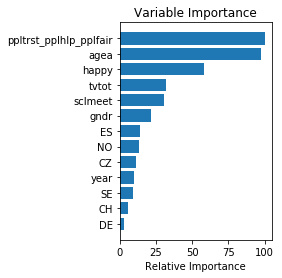

In [24]:
feature_importance2 = clf2.feature_importances_

# Make importances relative to max importance.
feature_importance2 = 100.0 * (feature_importance2 / feature_importance2.max())
sorted_idx2 = np.argsort(feature_importance2)
pos2 = np.arange(sorted_idx2.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos2, feature_importance2[sorted_idx2], align='center')
plt.yticks(pos2, X.columns[sorted_idx2])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

According to the best model, people's trust and faith in one another, along with their age, are the best indicators of a person's being in a partnership or not.  Following closely behind, is happiness.  This all makes sense because if people have faith in one another, they are more likely to develop close relationships, including partnerships with one another, and vice versa.  This faith in humanity then leads to overall happiness.  For these reasons, this model is a good predictor of a peron's relationship status. 